
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/75_Meta_Learning_MAML.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🧠 Meta-Learning (MAML): Learning to Learn

Standardowe AI uczy się jednego zadania (np. rozpoznawania psów).
Meta-Learning uczy się **jak się uczyć**.

Celem MAML jest znalezienie takich parametrów początkowych $\theta$, które po zobaczeniu zaledwie kilku przykładów (Few-Shot) i wykonaniu **jednego kroku gradientu**, idealnie dopasują się do nowego zadania.

**Mechanizm (Dwie pętle):**
1.  **Inner Loop (Szybka adaptacja):** Bierzemy kopię modelu. Pokazujemy jej 5 punktów z nowego zadania. Robimy jeden krok treningowy.
2.  **Outer Loop (Meta-aktualizacja):** Sprawdzamy, jak ta kopia radzi sobie na testowych danych. Jeśli dobrze -> nagradzamy **oryginalny model** (nie kopię), że był dobrym punktem startowym.

**Zadanie:** Regresja Sinusoidy.
Każde "zadanie" to inna sinusoida (inna amplituda i faza). Model widzi 5 punktów i musi narysować całą resztę.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

# Konfiguracja
DEVICE = "cpu" # MAML na prostym przykładzie działa szybciej na CPU (narzut kopiowania na GPU jest duży)
K_SHOT = 5     # Ile punktów widzi model? (Tylko 5!)
META_LR = 0.001 # Jak szybko uczy się "mózg matka"
INNER_LR = 0.01 # Jak szybko uczy się "kopia" (adaptacja)

print(f"Będziemy uczyć się sinusoidy na podstawie {K_SHOT} punktów.")

Będziemy uczyć się sinusoidy na podstawie 5 punktów.


## Generator Zadań

W Meta-Learningu naszymi "danymi" nie są obrazki, ale **zadania**.
Jedno zadanie = Jedna losowa sinusoida.
$$ y = A \sin(x + \phi) $$
Gdzie $A$ (Amplituda) i $\phi$ (Faza) są losowe.

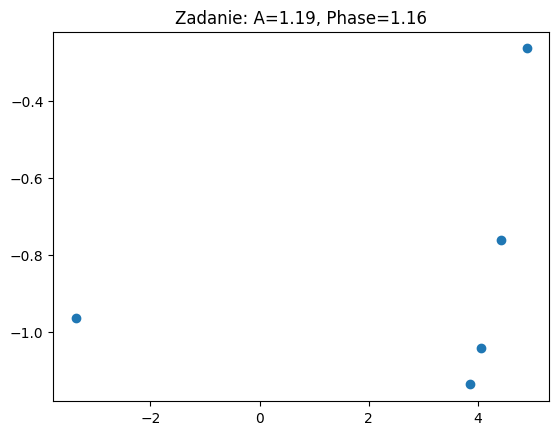

In [2]:
class SineWaveTask:
    def __init__(self):
        # Losujemy parametry fali
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, np.pi)
        
    def sample_data(self, k=5):
        # Losujemy x z zakresu -5 do 5
        x = np.random.uniform(-5, 5, size=(k, 1))
        # Liczymy y
        y = self.amplitude * np.sin(x + self.phase)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Zobaczmy przykładowe zadanie
task = SineWaveTask()
x_support, y_support = task.sample_data(K_SHOT)

plt.scatter(x_support, y_support)
plt.title(f"Zadanie: A={task.amplitude:.2f}, Phase={task.phase:.2f}")
plt.show()

## Model (Sieć Neuronowa)

Prosty MLP: 1 wejście (x) -> 40 ukrytych -> 40 ukrytych -> 1 wyjście (y).

In [3]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )
        
    def forward(self, x):
        return self.net(x)

# Inicjalizacja "Mózgu Matki" (Meta-Model)
meta_model = SimpleModel()
meta_optimizer = optim.Adam(meta_model.parameters(), lr=META_LR)
criterion = nn.MSELoss()

print("Meta-Model zainicjowany.")

Meta-Model zainicjowany.


## Algorytm MAML (Manualny Gradient)

To jest najtrudniejsza część. PyTorch domyślnie nie pozwala liczyć "pochodnej z pochodnej" (Second Order Derivative), chyba że użyjemy `create_graph=True`.

1.  Bierzemy wagi modelu (parametry $\theta$).
2.  Liczymy stratę na 5 punktach (Support Set).
3.  Liczymy gradient $\nabla L$.
4.  Tworzymy **Tymczasowe Wagi** (Fast Weights): $\theta' = \theta - \alpha \nabla L$.
5.  Używamy $\theta'$ do oceny nowych punktów (Query Set).
6.  Liczymy stratę na Query Set.
7.  Robimy Backprop aż do oryginalnych wag $\theta$.

Start Meta-Treningu...
Epizod 0, Meta-Loss: 11.8422
Epizod 200, Meta-Loss: 0.0304
Epizod 400, Meta-Loss: 2.1308
Epizod 600, Meta-Loss: 3.1550
Epizod 800, Meta-Loss: 3.0390
Epizod 1000, Meta-Loss: 1.2202
Epizod 1200, Meta-Loss: 1.2092
Epizod 1400, Meta-Loss: 0.2291
Epizod 1600, Meta-Loss: 1.2553
Epizod 1800, Meta-Loss: 5.8429


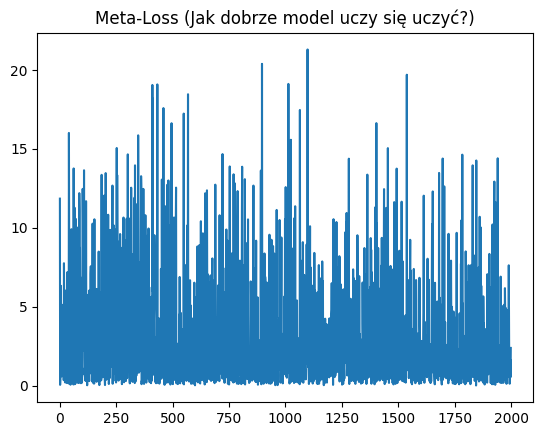

In [5]:
import torch.nn.functional as F

def meta_train_step(meta_model, meta_optimizer):
    # 1. Losujemy nowe zadanie (nową falę)
    task = SineWaveTask()
    
    # 2. Pobieramy dane do nauki (Support) i do sprawdzianu (Query)
    x_support, y_support = task.sample_data(K_SHOT) # 5 punktów
    x_query, y_query = task.sample_data(K_SHOT)     # Inne 5 punktów tej samej fali
    
    # 3. --- INNER LOOP (Szybka adaptacja) ---
    # Obliczamy predykcję na oryginalnych wagach
    preds = meta_model(x_support)
    loss = criterion(preds, y_support)
    
    # Obliczamy gradienty RĘCZNIE
    # create_graph=True jest kluczowe! Pozwala nam potem różniczkować ten krok.
    grads = torch.autograd.grad(loss, meta_model.parameters(), create_graph=True)
    
    # Tworzymy "Szybkie Wagi" (Fast Weights) - to jest symulacja kroku SGD
    # fast_weights = wagi - lr * grad
    fast_weights = {}
    for (name, param), grad in zip(meta_model.named_parameters(), grads):
        fast_weights[name] = param - INNER_LR * grad

    # 4. --- OUTER LOOP (Ocena adaptacji) ---
    # Teraz musimy użyć fast_weights do predykcji na Query Set.
    # W PyTorch nie da się łatwo podmienić wag w modelu funkcjonalnie,
    # więc użyjemy sztuczki: ręcznego forward passu (functional call) 
    # albo prostej reimplementacji forwardu na wagach słownikowych.
    
    # Uproszczony forward na słowniku wag (dla naszego MLP)
    def functional_forward(x, weights):
        x = F.linear(x, weights['net.0.weight'], weights['net.0.bias'])
        x = F.relu(x)
        x = F.linear(x, weights['net.2.weight'], weights['net.2.bias'])
        x = F.relu(x)
        x = F.linear(x, weights['net.4.weight'], weights['net.4.bias'])
        return x

    # Predykcja na "zaadaptowanym mózgu"
    preds_query = functional_forward(x_query, fast_weights)
    meta_loss = criterion(preds_query, y_query)
    
    # 5. Aktualizacja Meta-Modelu
    meta_optimizer.zero_grad()
    meta_loss.backward() # To liczy pochodną z całego procesu adaptacji!
    meta_optimizer.step()
    
    return meta_loss.item()

# TRENING (Meta-Training)
print("Start Meta-Treningu...")
losses = []
for i in range(2000): # 2000 epizodów
    loss = meta_train_step(meta_model, meta_optimizer)
    losses.append(loss)
    if i % 200 == 0:
        print(f"Epizod {i}, Meta-Loss: {loss:.4f}")

plt.plot(losses)
plt.title("Meta-Loss (Jak dobrze model uczy się uczyć?)")
plt.show()

## Wielki Test: Adaptacja w locie

Sprawdźmy to.
1.  Wylosujemy zupełnie nową falę (Zadanie, którego model nigdy nie widział).
2.  Pokażemy modelowi **tylko 5 punktów**.
3.  Zrobimy **jeden krok** aktualizacji wag.
4.  Sprawdzimy, czy model "zrozumiał", o jaką falę chodzi.

Porównamy to z modelem "głupim" (przed adaptacją).

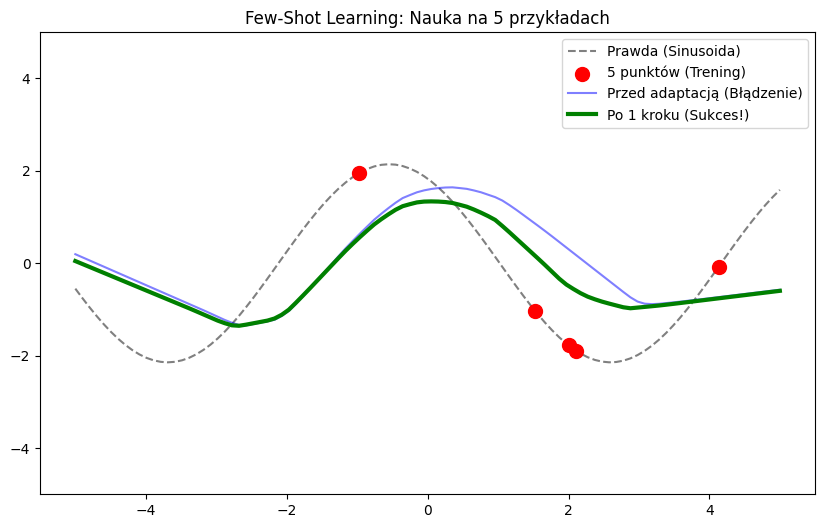

In [6]:
# Nowe zadanie testowe
test_task = SineWaveTask()
x_supp, y_supp = test_task.sample_data(K_SHOT)

# 1. Model PRZED adaptacją (Zero-shot)
# Powinien zwrócić coś uśrednionego (np. płaską linię albo średnią sinusoidę)
with torch.no_grad():
    x_range = torch.linspace(-5, 5, 100).unsqueeze(1)
    y_pred_before = meta_model(x_range)

# 2. ADAPTACJA (One-step Fine-tuning)
# Klonujemy model, żeby nie zepsuć oryginału
adapted_model = copy.deepcopy(meta_model)
adapt_opt = optim.SGD(adapted_model.parameters(), lr=INNER_LR)

# Jeden krok treningu na 5 punktach!
pred = adapted_model(x_supp)
loss = criterion(pred, y_supp)
adapt_opt.zero_grad()
loss.backward()
adapt_opt.step()

# 3. Model PO adaptacji (Few-shot)
with torch.no_grad():
    y_pred_after = adapted_model(x_range)

# WIZUALIZACJA
plt.figure(figsize=(10, 6))
# Prawdziwa fala
y_true = test_task.amplitude * np.sin(x_range.numpy() + test_task.phase)
plt.plot(x_range, y_true, label='Prawda (Sinusoida)', color='gray', linestyle='--')

# Punkty, które widział model (tylko 5!)
plt.scatter(x_supp, y_supp, color='red', s=100, label='5 punktów (Trening)', zorder=5)

# Predykcje
plt.plot(x_range, y_pred_before, label='Przed adaptacją (Błądzenie)', color='blue', alpha=0.5)
plt.plot(x_range, y_pred_after, label='Po 1 kroku (Sukces!)', color='green', linewidth=3)

plt.legend()
plt.title(f"Few-Shot Learning: Nauka na 5 przykładach")
plt.ylim(-5, 5)
plt.show()

## 🧠 Podsumowanie: Mądry Start

Jeśli zielona linia ("Po 1 kroku") dopasowała się do szarej sinusoidy (mimo że widziała tylko 5 czerwonych kropek), to **MAML zadziałał**.

Model nie nauczył się "wszystkich sinusoid na pamięć".
Nauczył się takiej konfiguracji wag, która jest **niezwykle plastyczna**. Wystarczy lekkie pchnięcie gradientem w oparciu o 5 punktów, żeby wagi "wskoczyły" na właściwą orbitę.

To fundament nowoczesnej robotyki (robot widzi nowy przedmiot raz i wie jak go chwycić) oraz systemów GPT (In-Context Learning).